### **本节引入卷积神经网络（CNN）基本概念**

**CNN的基本框架（与全连接网络的对比）**：

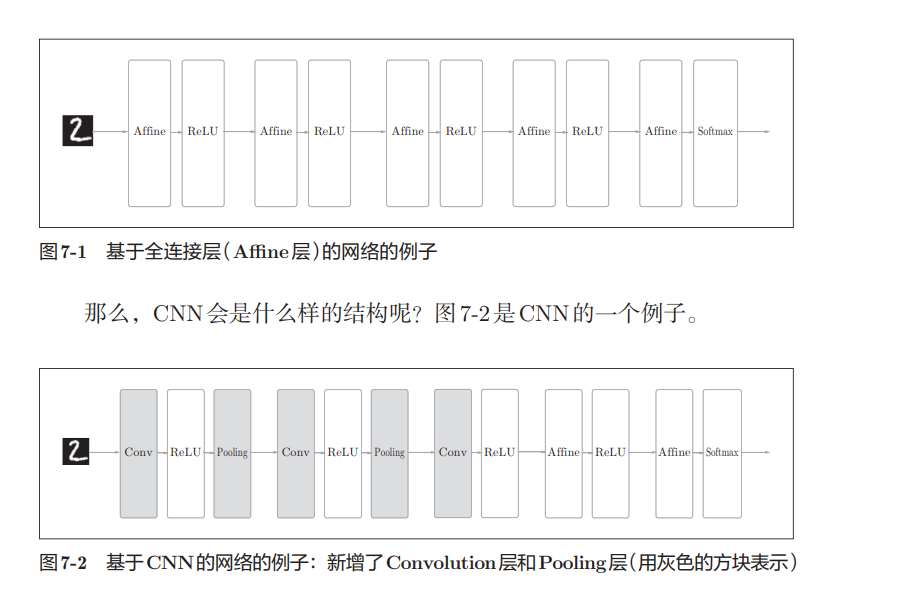

**一，卷积层**

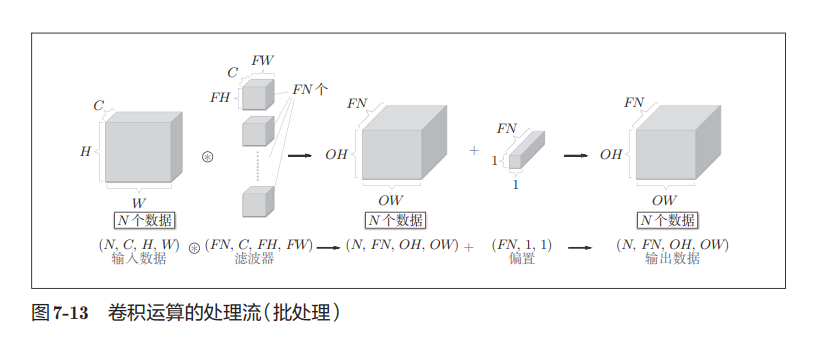

**二，池化层**

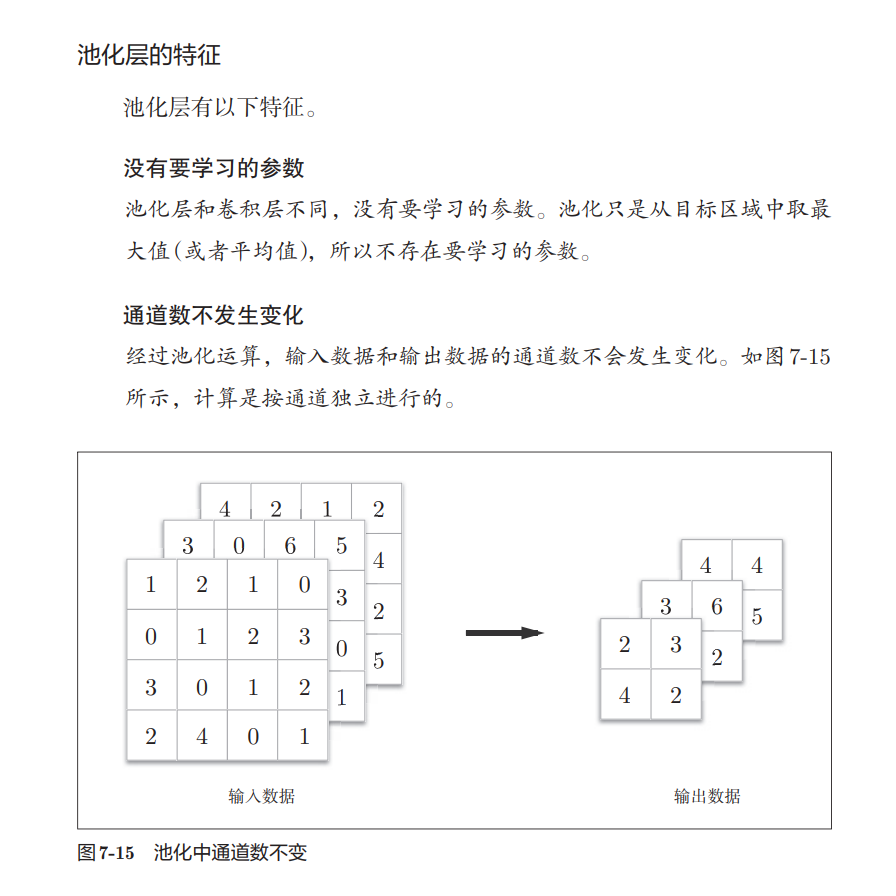

***

In [1]:
# 导入包
import numpy as np
import my_frame as mf
import matplotlib.pyplot as plt

In [2]:
# 随机生成4维数据
x = np.random.rand(10,1,28,28) # 对应10个通道数为1，长，高为28的数据
print(x.shape)
print(x[0].shape)
print(x[0,0].shape,x[0][0].shape)

(10, 1, 28, 28)
(1, 28, 28)
(28, 28) (28, 28)


像这样，CNN中处理的是4维数据，因此卷积运算的实现看上去会很复  
杂，但是通过使用下面要介绍的im2col这个技巧，问题就会变得很简单

**基于im2col的展开如图**：

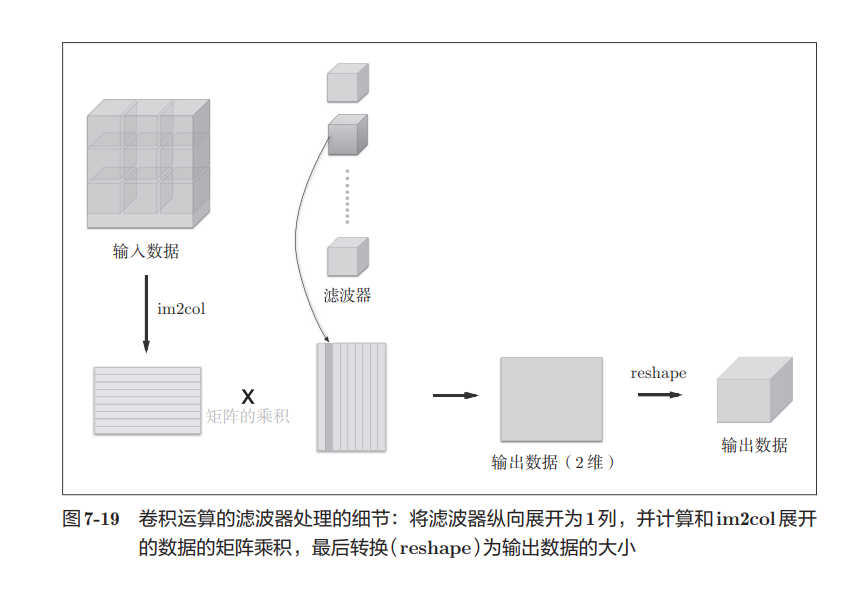

**注意**：

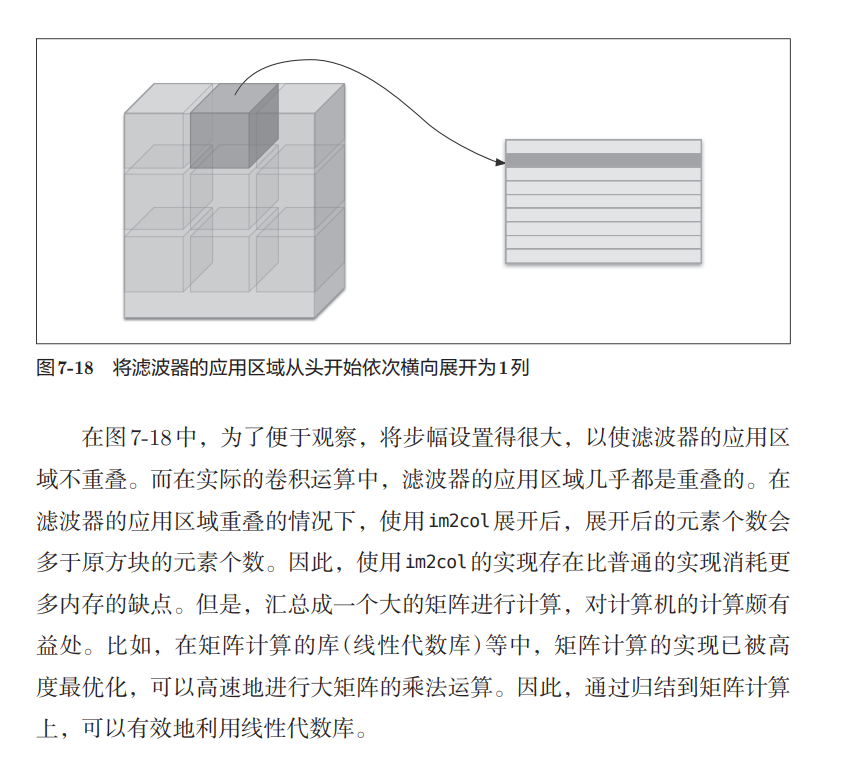

***
下面举例用一下im2col函数

In [4]:
# 生成4维数据(数据量，通道，长，高)
x = np.random.rand(1,3,7,7)

# 计算展开式
coll = mf.im2col(x,5,5,stride = 1,pad = 0) # 适配的滤波器长高为(5,5)，步幅 = 1，填充 = 0
print(coll.shape)

x = np.random.rand(10,3,7,7)
coll = mf.im2col(x,5,5,stride = 1,pad = 0)
print(coll.shape)

# 显然，当数据量扩大到10倍，展开的大小也扩大到10倍

(9, 75)
(90, 75)


**输出数据大小计算公式**

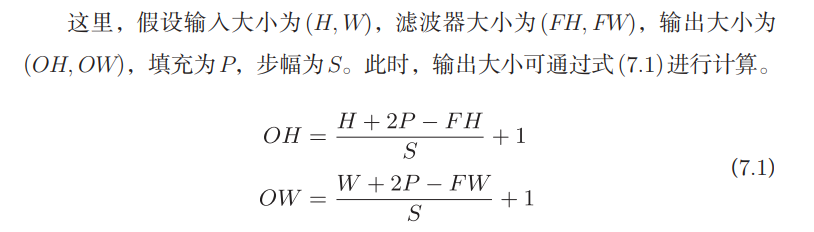

**下面是代码实现卷积层**

In [1]:
# 定义卷积层的类
class Convolution:
    """卷积层的实现"""
    
    def __init__(self,W,b,stride = 1,pad = 0):
        self.W = W # 对于CNN而言，滤波器就是权重矩阵
        self.b = b
        self.stride = stride
        self.pad = pad

        # 中间数据（backward时使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 权重和偏置参数的梯度
        self.dW = None
        self.db = None

    def forward(self,x):
        FN,C,FH,FW = self.W.shape # 获取滤波器数据
        N,C,H,W = x.shape # 获取输入矩阵数据

        # 计算输出数据大小
        out_h= int(1 + (H + 2*self.pad - FH)/self.stride)
        out_w = int(1 + (W + 2*self.pad - FW)/self.stride)

        # 展开
        col = mf.im2col(x,FH,FW,self.stride,self.pad)
        col_W = self.W.reshape(FN,-1).T # 滤波器的展开
        out = np.dot(col,col_W) + self.b
        out = out.reshape(N,out_h,out_w,-1).transpose(0,3,1,2) # 还原数据，由于矩阵运算，打乱了矩阵顺序，transpos调整通道

        self.x = x
        self.col = col
        self.col_W = col_W

        return out
    
    # 原理基本与Affine层一致，但是其中的矩阵转化有点复杂
    def backward(self, dout):
        """卷积层的反向传播"""
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = mf.col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

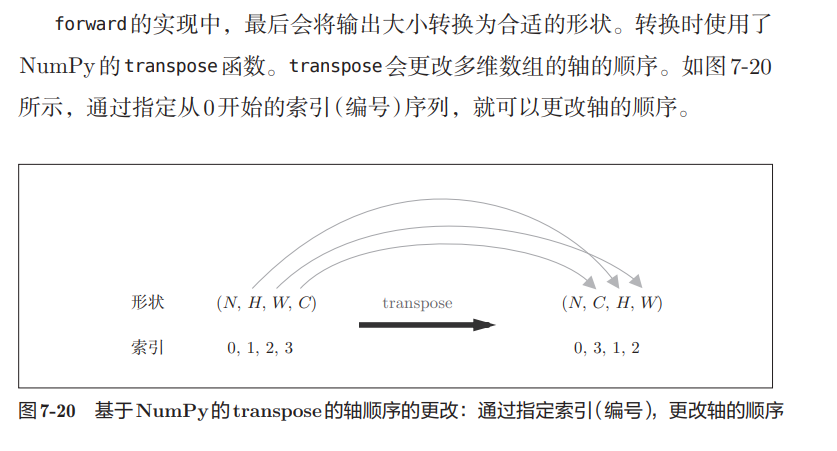

***

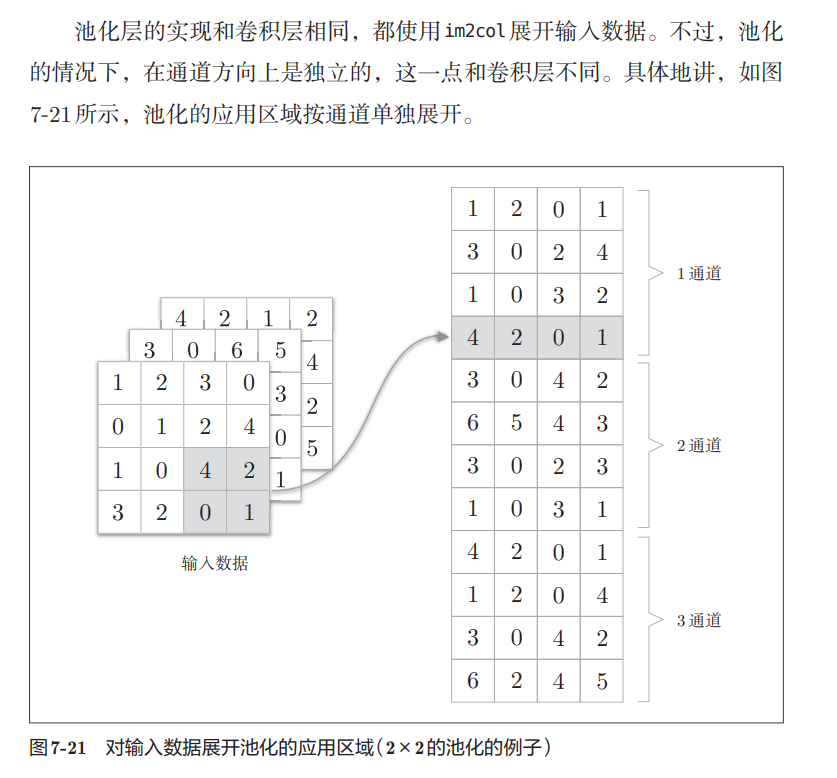

**池化层实现的基本阶段**：  
1.展开输入数据。  
2.求各行的最大值。  
3.转换为合适的输出大小。  

**下面代码实现池化层**

In [5]:
# 定义池化层的类
class Pooling:
    """池化层的实现"""
    def __init__(self,pool_h,pool_w,stride = 1,pad = 0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        # 传播所需
        self.x = None
        self.arg_max = None

    def forward(self,x):
        N,C,H,W = x.shape
        out_h = int(1 + (H - self.pool_h)/self.stride)
        out_w = int(1 + (W - self.pool_w)/self.stride)

        # 展开
        col = mf.im2col(x,self.pool_h,self.pool_w,self.stride,self.pad)
        col = col.reshape(-1,self.pool_h*self.pool_w)

        # 进行取最大值操作
        arg_max = np.argmax(col, axis=1)
        out = np.max(col,axis = 1)

        # 转换
        out = out.reshape(N,out_h,out_w,C).transpose(0,3,1,2)

        # 保存用于backward
        self.x = x
        self.arg_max = arg_max

        return out
    
    # 反向传播基本原理与relu相似，但是代码难理解
    def backward(self,dout): 
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = mf.col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx
